# evaluation
> This module evaluating RL agents on the electricity market environment.

In [ ]:
# | default_exp evaluation

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import itertools
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rliable.metrics
import rliable.plot_utils
import seaborn as sns

from electricity_market.env import ElectricityMarketEnv
from electricity_market.player import (
    A2CAgent,
    MaskablePPOAgent,
    MaskableRandomAgent,
    expert_knowledge_action_masks,
    is_action_safe,
)
from electricity_market.utils import EvaluationData

In [ ]:
# | export


def plot_all_metrics(
    agent_eval_data: dict[str, EvaluationData],
):
    sns.set_theme(style="whitegrid")

    def plot_aggregate_metrics():
        metrics = {
            "IQM": [],
            "Median": [],
            "Mean": [],
        }
        agent_names = list(agent_eval_data.keys())

        for agent, data in agent_eval_data.items():
            rewards_matrix = np.array(data.rewards).reshape(len(data.rewards), 1)

            metrics["IQM"].append(rliable.metrics.aggregate_iqm(rewards_matrix))
            metrics["Median"].append(rliable.metrics.aggregate_median(rewards_matrix))
            metrics["Mean"].append(rliable.metrics.aggregate_mean(rewards_matrix))

        # Create subplots for each metric
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for ax, (metric_name, values) in zip(axes, metrics.items()):
            sns.barplot(
                x=agent_names,
                y=values,
                ax=ax,
                hue=agent_names,
                palette="tab10",
                capsize=0.1,
                legend=False,
            )
            ax.set_title(f"{metric_name} Reward")
            ax.set_xlabel("Agent")
            ax.set_ylabel("Reward")
            ax.tick_params(axis="x", rotation=45)

        plt.suptitle("Aggregate Evaluation Metrics (rliable)")
        plt.tight_layout()
        plt.show()

    def plot_probability_of_improvement():
        # Create a list of all agents (keys from agent_eval_data)
        agents = list(agent_eval_data.keys())

        # Dictionaries to hold the probability estimates and interval estimates
        probability_estimates = {}
        probability_interval_estimates = {}

        # Compare each pair of agents using itertools.combinations
        for agent1, agent2 in itertools.combinations(agents, 2):
            # Get the rewards for each agent as lists
            rewards1 = agent_eval_data[agent1].rewards
            rewards2 = agent_eval_data[agent2].rewards

            rewards1_reshaped = np.array(rewards1).reshape(len(rewards1), 1)
            rewards2_reshaped = np.array(rewards2).reshape(len(rewards2), 1)

            # Calculate the probability of improvement between the two agents
            prob_improvement = rliable.metrics.probability_of_improvement(
                rewards1_reshaped, rewards2_reshaped
            )

            # Calculate the confidence intervals (e.g., bootstrap method, here assuming it is available)
            # If you have an existing method to calculate the intervals, apply it
            # For simplicity, we use placeholders here
            prob_interval = [0.0, 1.0]  # Replace with actual interval calculation

            # Store the probability and interval estimates
            pair = f"{agent1},{agent2}"
            probability_estimates[pair] = prob_improvement
            probability_interval_estimates[pair] = prob_interval

        # Plot the probability of improvement using the rliable function
        rliable.plot_utils.plot_probability_of_improvement(
            probability_estimates,
            probability_interval_estimates,
            ax=None,
            figsize=(8, 6),
            colors=None,
            color_palette="colorblind",
            alpha=0.75,
            xlabel="P(X > Y)",
            left_ylabel="Algorithm X",
            right_ylabel="Algorithm Y",
        )

        plt.title("Probability of Improvement between Algorithms")
        plt.show()

    # Call all the plot functions
    plot_aggregate_metrics()
    plot_probability_of_improvement()

In [ ]:
# | exports
with open("evaluation_data_per_agent.pkl", "rb") as f:
    evaluation_data_per_agent = pickle.load(f)

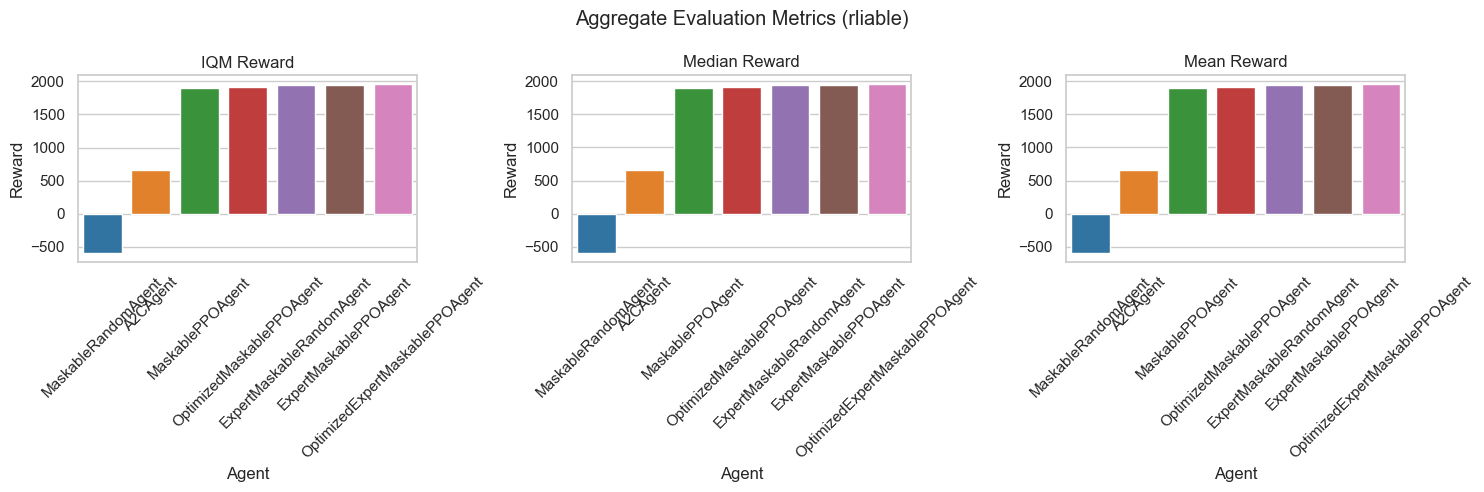

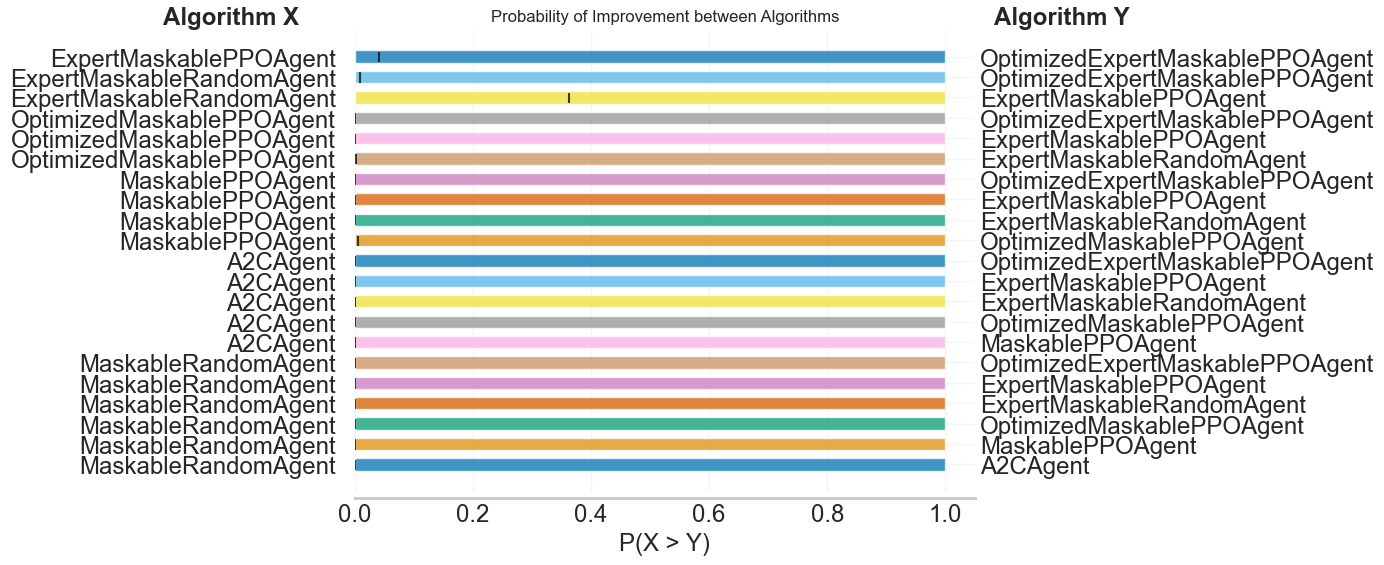

In [ ]:
# | exports
plot_all_metrics(evaluation_data_per_agent)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

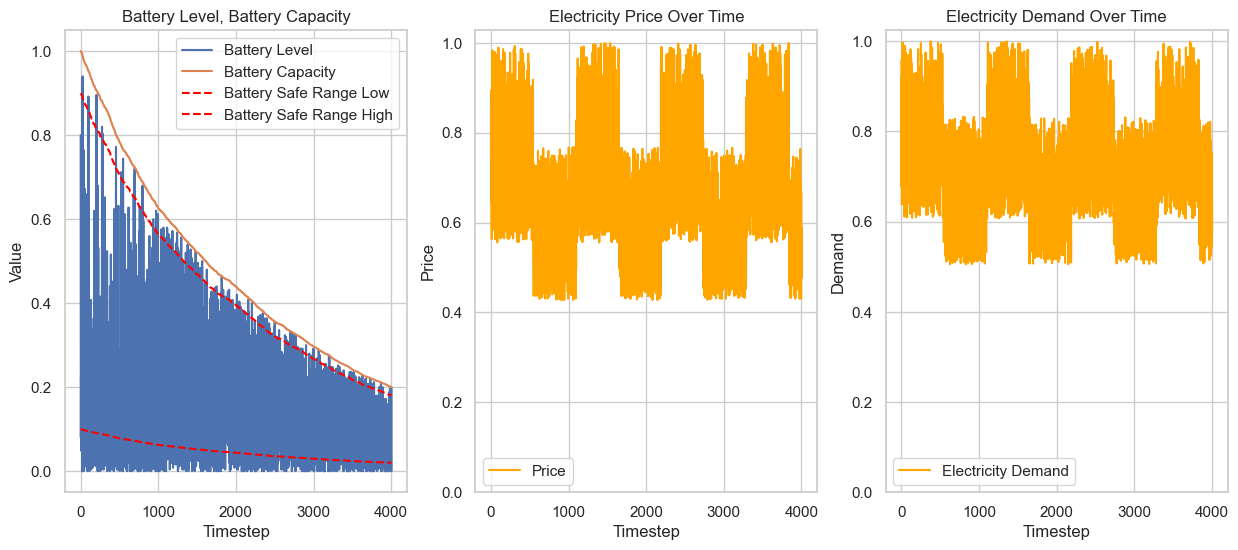

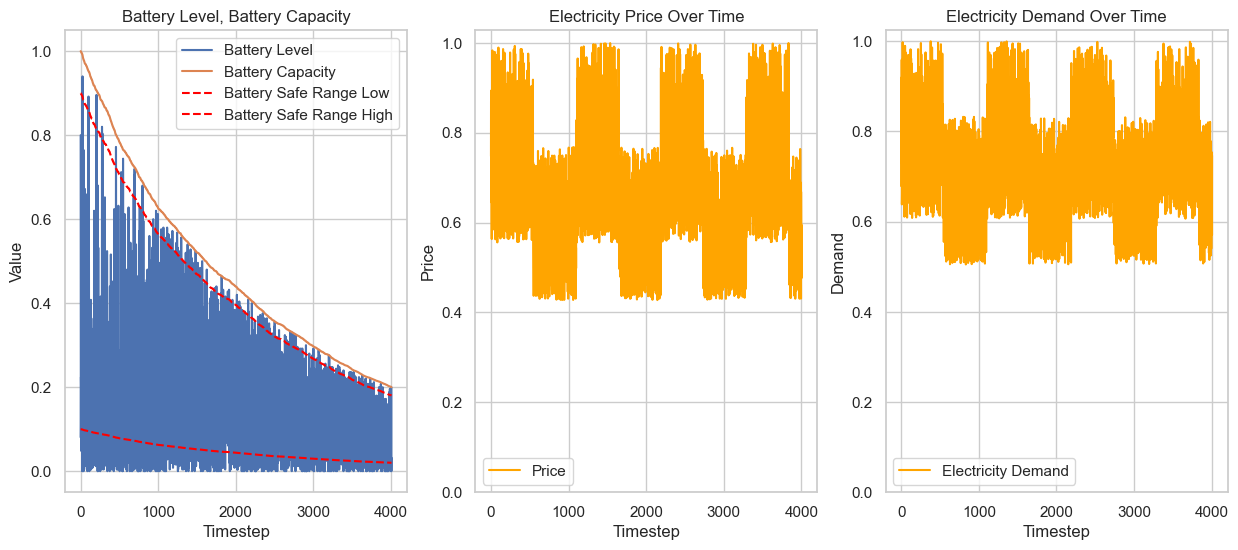

EvaluationData(episodes=[0], rewards=[-593.2344399917255])

In [ ]:
# | exports
maskable_random_agent = MaskableRandomAgent()
maskable_random_agent.evaluate(render=True)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

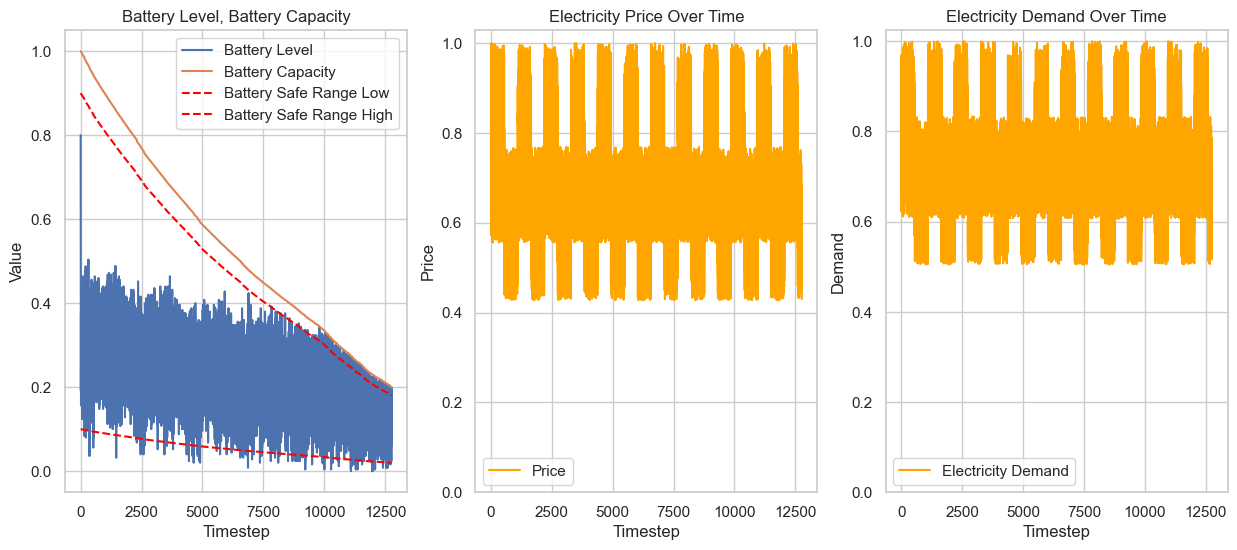

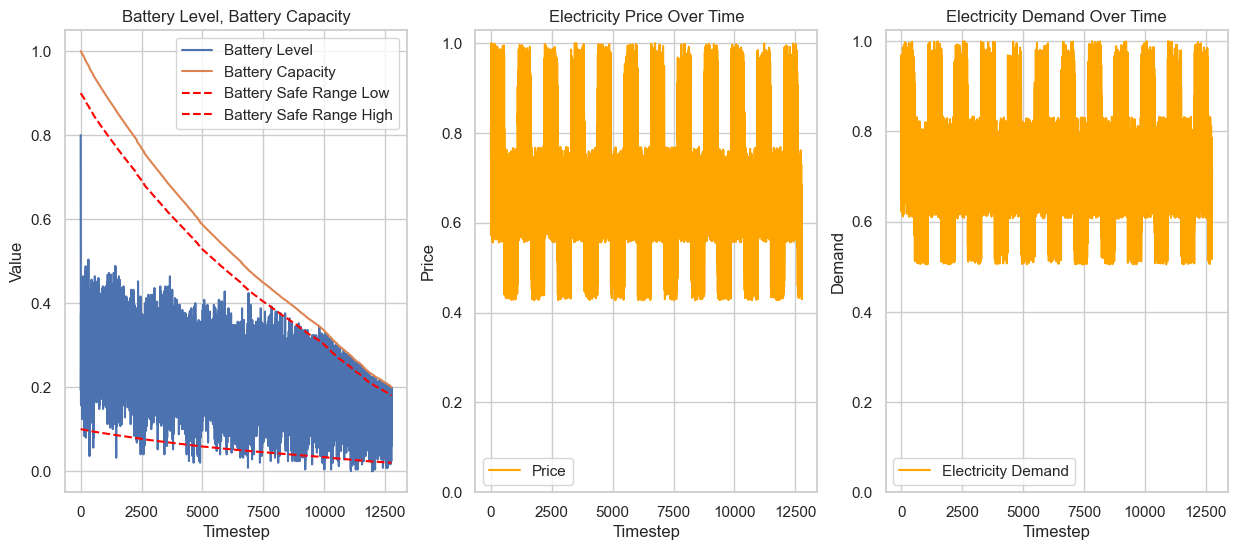

EvaluationData(episodes=[0], rewards=[616.3711677522796])

In [ ]:
# | exports
a2c_agent = A2CAgent()
a2c_agent.load_model(Path("../trained_models/A2CAgent.model"))
a2c_agent.evaluate(render=True)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

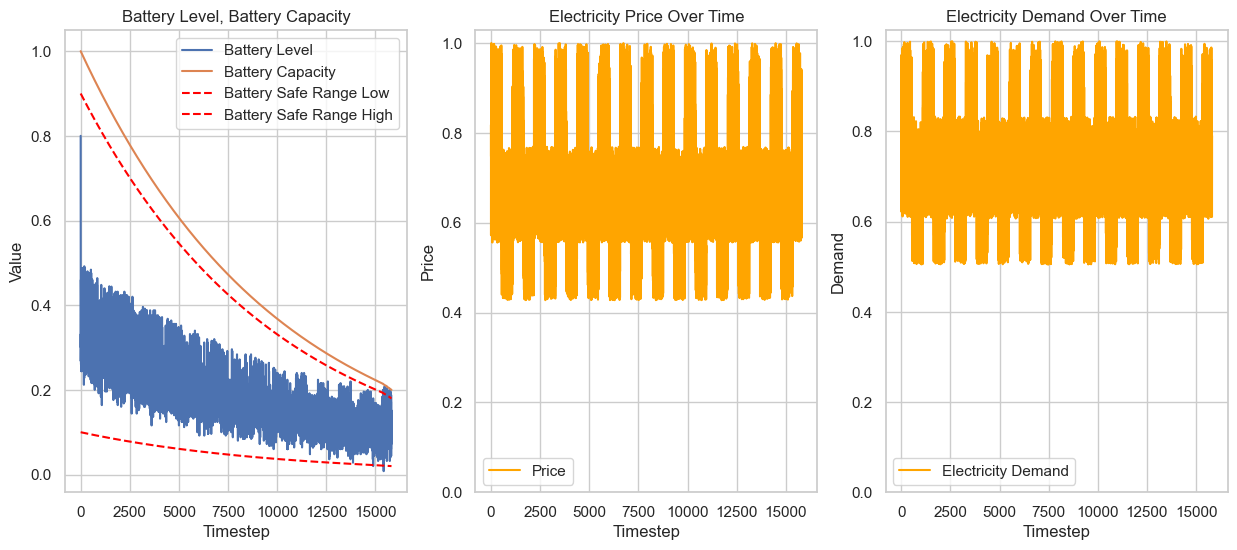

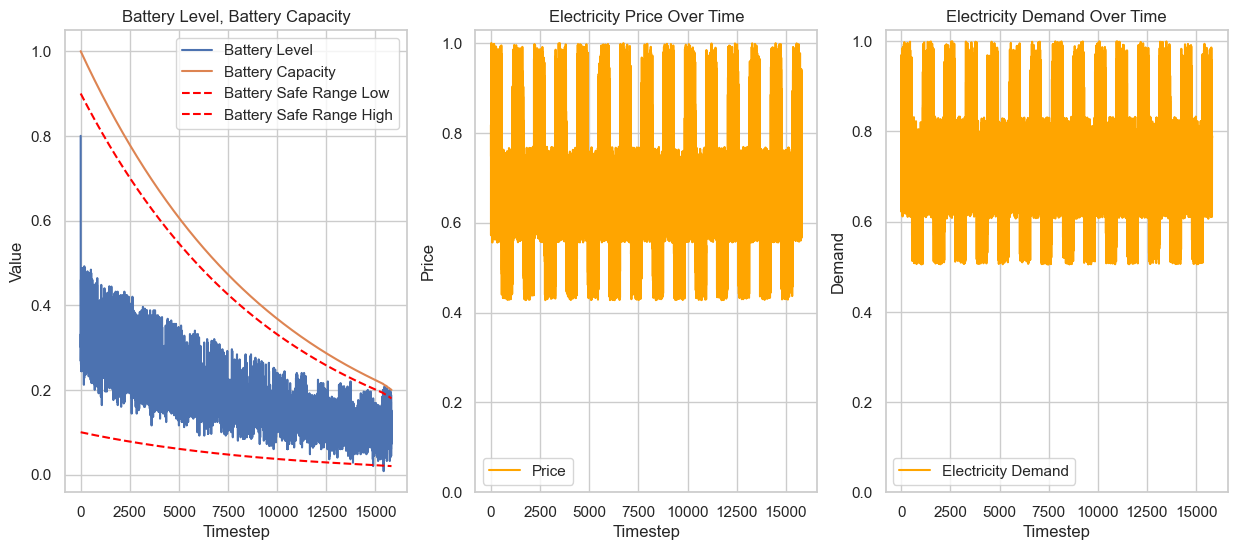

EvaluationData(episodes=[0], rewards=[1860.4983018611665])

In [ ]:
# | exports
maskable_ppo_agent = MaskablePPOAgent()
maskable_ppo_agent.load_model(Path("../trained_models/MaskablePPOAgent.model"))
maskable_ppo_agent.evaluate(render=True)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

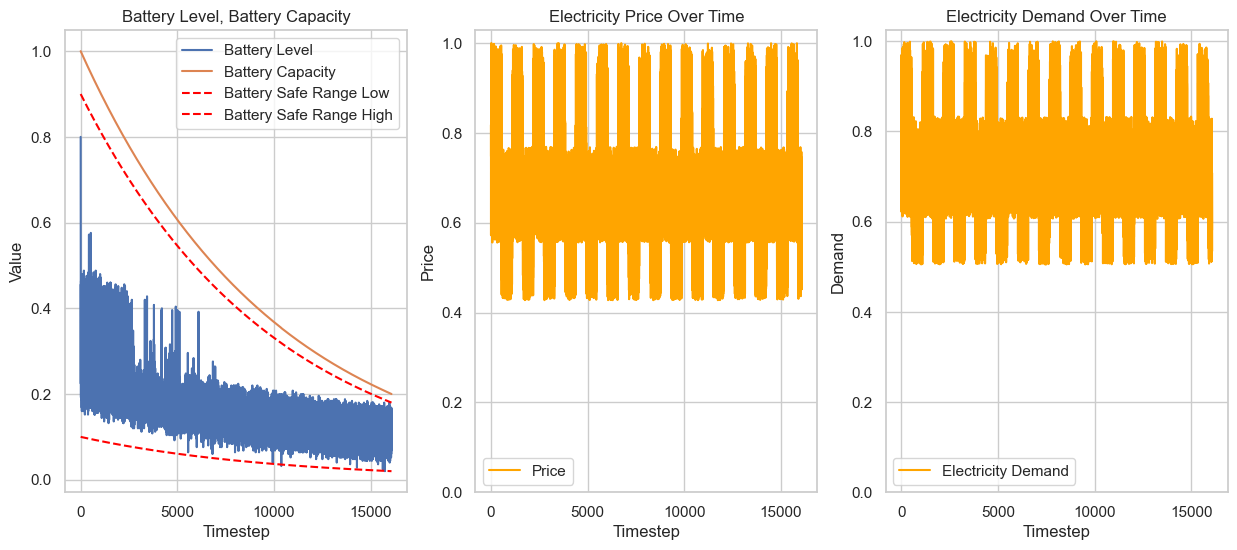

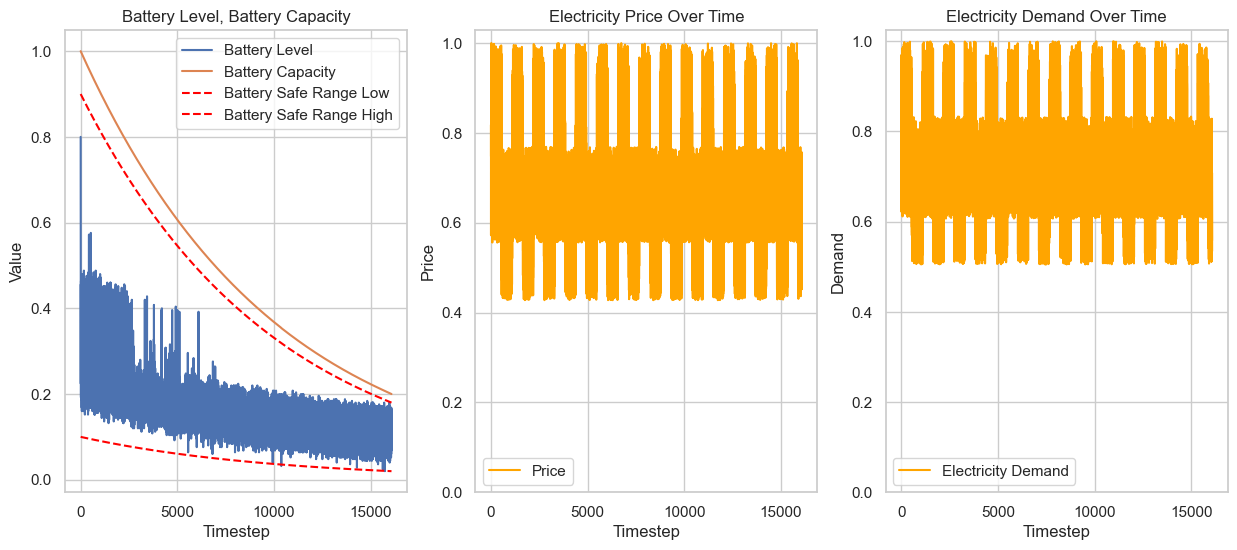

EvaluationData(episodes=[0], rewards=[1916.1345892815057])

In [ ]:
# | exports
optimized_maskable_ppo_agent = MaskablePPOAgent()
optimized_maskable_ppo_agent.load_model(
    Path("../trained_models/OptimizedMaskablePPOAgent.model")
)
optimized_maskable_ppo_agent.evaluate(render=True)

In [ ]:
# | exports
# Dynamically overriding action_masks to ElectricityMarketEnv
setattr(ElectricityMarketEnv, "action_masks", expert_knowledge_action_masks)
# Dynamically overriding injection is_action_safe to ElectricityMarketEnv
setattr(ElectricityMarketEnv, "is_action_safe", is_action_safe)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

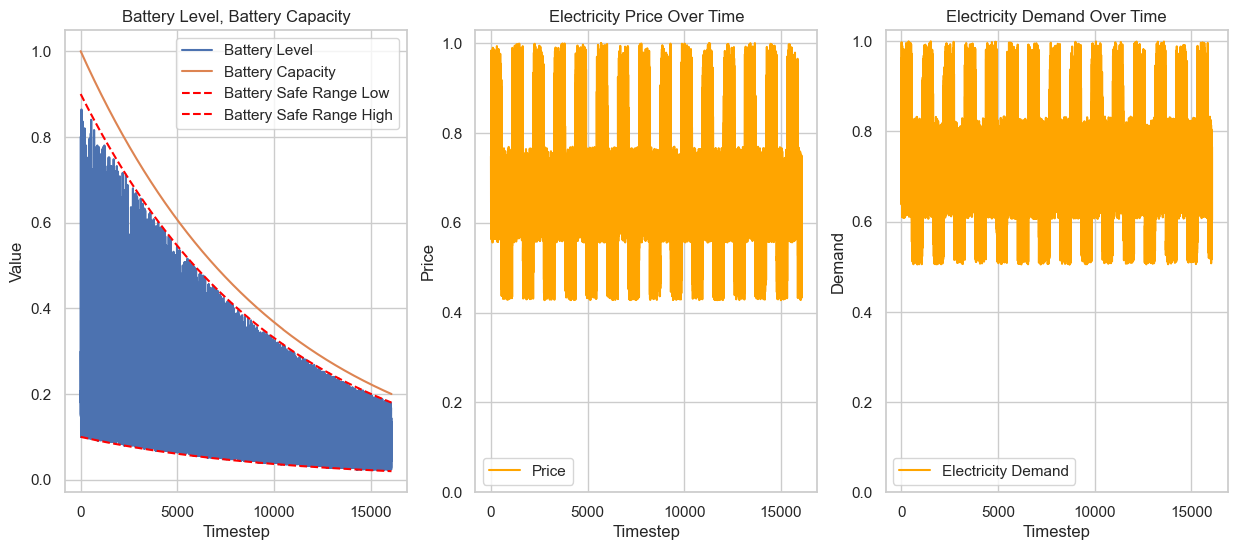

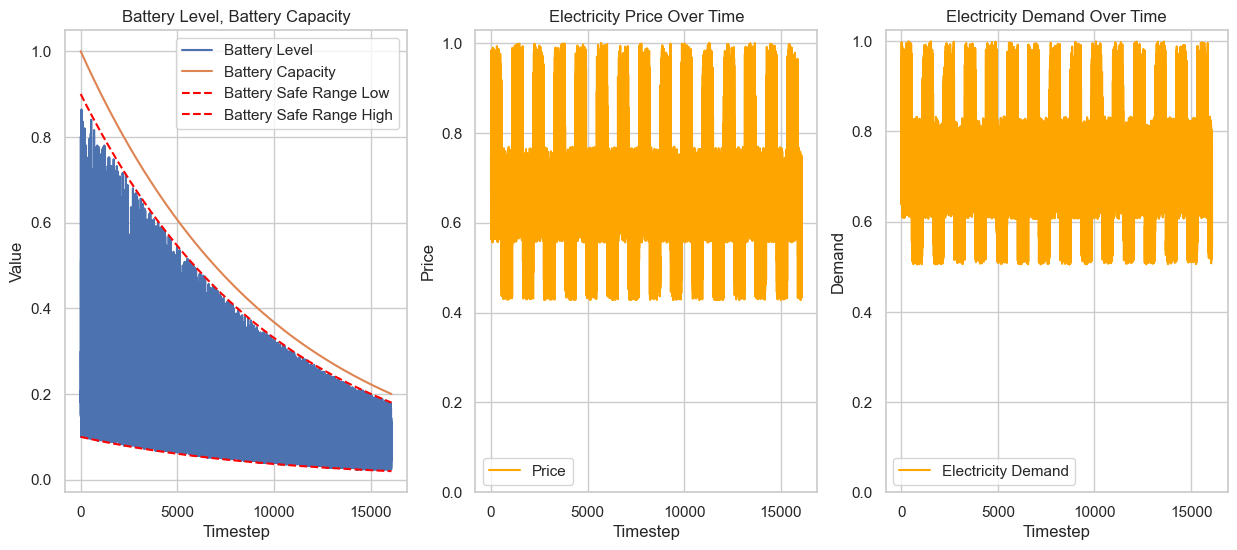

EvaluationData(episodes=[0], rewards=[1942.8131128843397])

In [ ]:
# | exports
expert_maskable_random_agent = MaskableRandomAgent()
expert_maskable_random_agent.evaluate(render=True)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

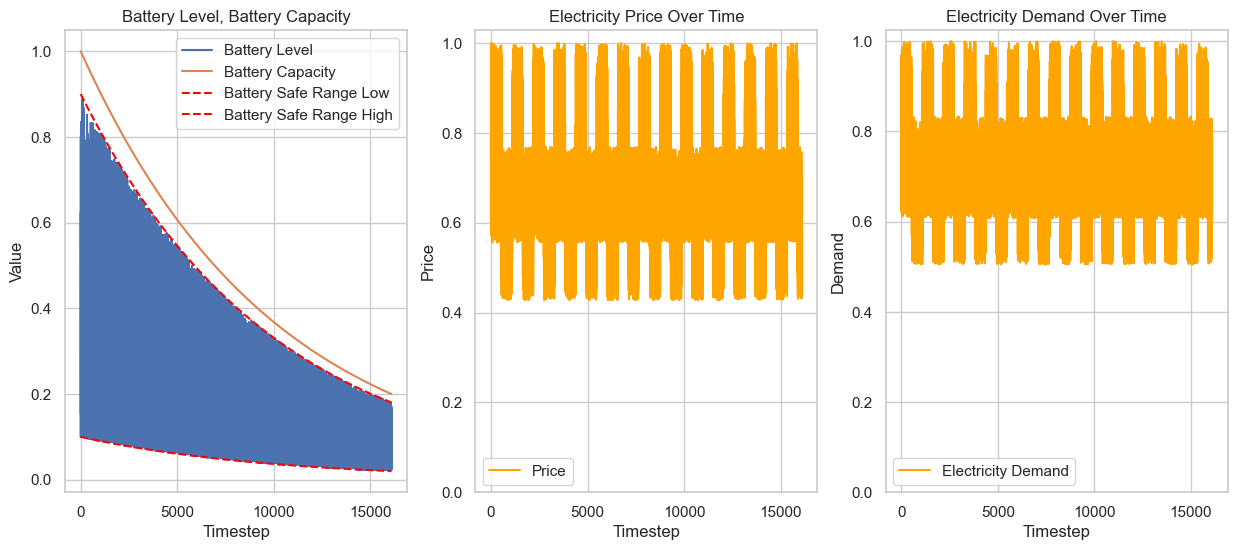

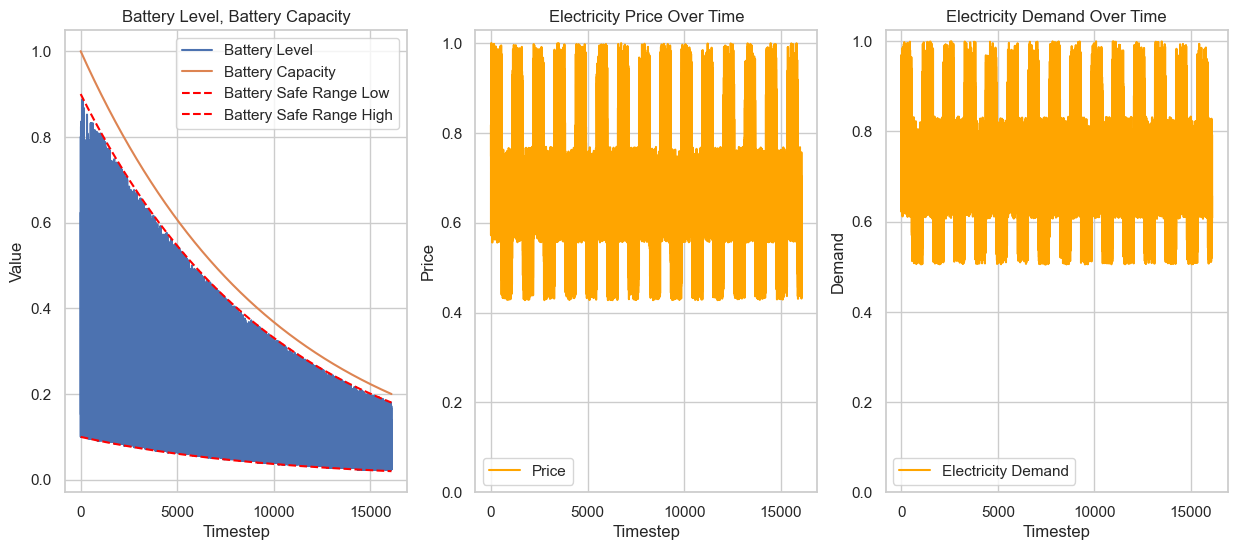

EvaluationData(episodes=[0], rewards=[1952.1434882662197])

In [ ]:
# | exports
expert_maskable_ppo_agent = MaskablePPOAgent()
expert_maskable_ppo_agent.load_model(
    Path("../trained_models/ExpertMaskablePPOAgent.model")
)
expert_maskable_ppo_agent.evaluate(render=True)

seeds:   0%|          | 0/1 [00:00<?, ?it/s]

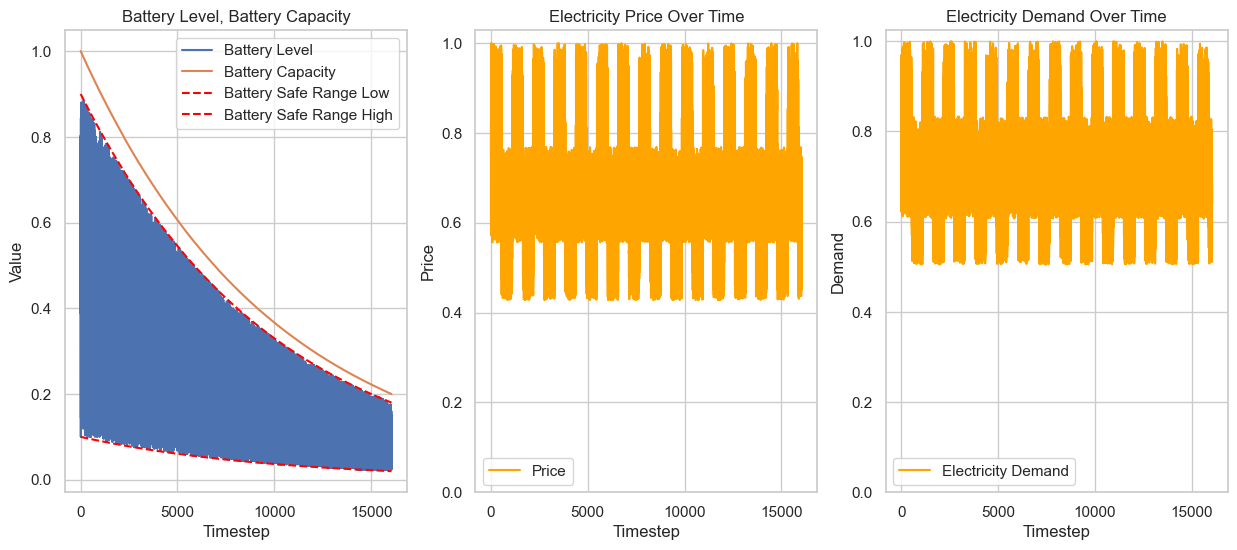

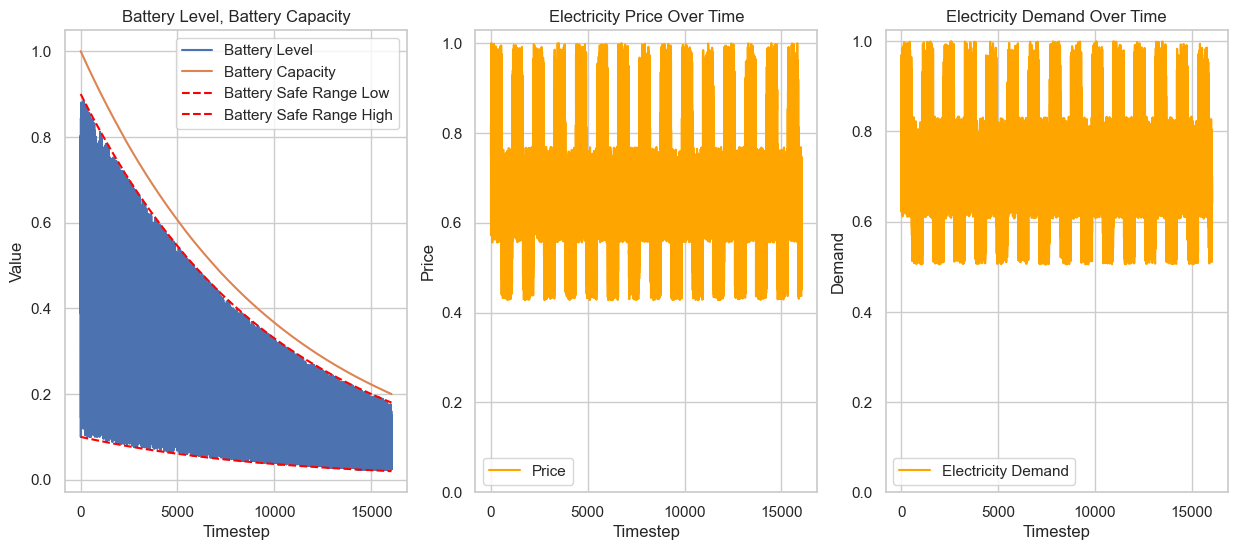

EvaluationData(episodes=[0], rewards=[1955.779148283058])

In [ ]:
# | exports
optimized_expert_maskable_ppo_agent = MaskablePPOAgent()
optimized_expert_maskable_ppo_agent.load_model(
    Path("../trained_models/OptimizedExpertMaskablePPOAgent.model")
)
optimized_expert_maskable_ppo_agent.evaluate(render=True)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()